# Example 2: MNIST demo

This Colab notebook accompanies the [JAX on the Web with TensorFlow.js](https://blog.tensorflow.org/2022/08/jax-on-web-with-tensorflowjs.html) blog post.

## Setup code

In [ ]:
# Model below trains in ~1 min on a NVIDIA Tesla T4 GPU.
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-d096983f-b019-4f32-1f5f-edeece119a3d)


In [ ]:
!pip install -q flax ml_collections
!pip install -q --upgrade git+https://github.com/google/jax tensorflowjs

     |████████████████████████████████| 180 kB 5.0 MB/s 
     |████████████████████████████████| 77 kB 7.4 MB/s 
     |████████████████████████████████| 145 kB 54.2 MB/s 
     |████████████████████████████████| 1.0 MB 65.0 MB/s 
     |████████████████████████████████| 217 kB 46.8 MB/s 
     |████████████████████████████████| 51 kB 4.2 MB/s 
     |████████████████████████████████| 76 kB 3.7 MB/s 
     |████████████████████████████████| 81 kB 3.9 MB/s 
     |████████████████████████████████| 40 kB 6.1 MB/s 


## Train the MNIST classifier

Code **copied** from official Flax MNIST example Colab
https://colab.research.google.com/github/google/flax/blob/main/examples/mnist/mnist.ipynb


In [ ]:
# Some useful imports.

from matplotlib import pyplot as plt
import numpy as np

from absl import logging
logging.set_verbosity(logging.INFO)

In [ ]:
# Clone the repository from GitHub and open in editor.

import os
os.chdir('/content')
if not os.path.isdir('flaxrepo'):
  !git clone --depth=1 https://github.com/google/flax flaxrepo
os.chdir('flaxrepo/examples/mnist')

from google.colab import files
files.view('train.py')

# Import `train.py`.
%load_ext autoreload
%autoreload 2
import train
# Import from `configs/default.py`
# and instantiate the default hyperparameter configuration.
from configs import default as config_lib
config = config_lib.get_config()
# config.num_epochs = 1  # fast training, e.g. for CPU
config

Cloning into 'flaxrepo'...
remote: Enumerating objects: 360, done.
remote: Counting objects: 100% (360/360), done.
remote: Compressing objects: 100% (317/317), done.
remote: Total 360 (delta 55), reused 170 (delta 29), pack-reused 0
Receiving objects: 100% (360/360), 2.22 MiB | 19.24 MiB/s, done.
Resolving deltas: 100% (55/55), done.


<IPython.core.display.Javascript object>

batch_size: 128
learning_rate: 0.1
momentum: 0.9
num_epochs: 10

In [ ]:
# Load the dataset, split into the training and test sets, and train the model.
train_ds, test_ds = train.get_datasets()
state = train.train_and_evaluate(config, workdir=f'./workdir')

INFO:absl:Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: mnist/3.0.1
INFO:absl:Load dataset info from /tmp/tmpd5o32k9ptfds
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.splits from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.supervised_keys from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.module_name from disk and from code do not match. Keeping the one from code.
INFO:absl:Generating dataset mnist (~/tensorflow_datasets/mnist/3.0.1)


INFO:absl:Dataset mnist is hosted on GCS. It will automatically be downloaded to your
local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

INFO:absl:Load dataset info from ~/tensorflow_datasets/mnist/3.0.1.incompleteEJINM9
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.splits from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.supervised_keys from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.module_name from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.file_format from disk and from code do not match. Keeping the one from code.
INFO:absl:Constructing tf.data.Dataset mnist for split train, from ~/tensorflow_datasets/mnist/3.0.1


Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


INFO:absl:Constructing tf.data.Dataset mnist for split test, from ~/tensorflow_datasets/mnist/3.0.1
INFO:absl:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO:absl:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter CUDA Host
INFO:absl:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
INFO:absl:Load dataset info from ~/tensorflow_datasets/mnist/3.0.1
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.splits from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.supervised_keys from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.module_name from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (~/tensorflow_datasets/mni

shape=(5, 28, 28, 1); value range [0.0..1.0]


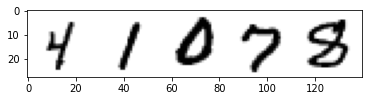

In [ ]:
# Sanity check: Load some images ...
imgs = np.array(train_ds['image'][:5])
plt.imshow(np.hstack(imgs)[..., 0], cmap='gray_r')
print(f'shape={imgs.shape}; value range [{imgs.min():.2}..{imgs.max():.2}]')

In [ ]:
# ... and confirm that model produces matching predictions.
logits = state.apply_fn({'params': state.params}, imgs)
logits.argmax(axis=1)

DeviceArray([4, 1, 0, 7, 8], dtype=int32)

## Convert the model

The following code was copied/modified from the previous Colab notebook in the blog post section about
[converting a simple JAX function](https://colab.research.google.com/github/andsteing/JaxOnTheWeb/blob/main/converting-a-simple-jax-function.ipynb)


In [ ]:
# from jax.experimental.jax2tf.examples import jax2tfjs
import tensorflowjs as tfjs
import tensorflow as tf

In [ ]:
tfjs_model_dir = f'tfjs_model'
tfjs.converters.convert_jax(
    state.apply_fn,
    {'params': state.params},
    input_signatures=[tf.TensorSpec((1, 28, 28, 1), tf.float32)],
    model_dir=tfjs_model_dir,
)

Writing weight file tfjs_model/model.json...


In [ ]:
# ~3 MB of parameters.
!ls -lh ./tfjs_model

total 3.2M
-rw-r--r-- 1 root root 3.2M Aug 29 09:03 group1-shard1of1.bin
-rw-r--r-- 1 root root 9.7K Aug 29 09:03 model.json


## js demo

In [ ]:
# Fetch minimal MNIST UI and show the code.
!wget -q -O mnist_ui.js https://gist.githubusercontent.com/andsteing/86b6dbc7e04e53a709dfa04107909552/raw/84796208ae39a042f5bfbadf7a420379823ad905/mnist_ui.js
files.view('mnist_ui.js')

<IPython.core.display.Javascript object>

In [ ]:
# Create index.html loading exported model
with open('index.html', 'w') as f:
  # use `HTML()` for syntax highlighting B)
  HTML = lambda s: s
  f.write(HTML('''
<!DOCTYPE html>
<meta charset="utf-8" />
<meta name="viewport" content="width=device-width, initial-scale=1, user-scalable=no">
<script src="https://cdn.jsdelivr.net/npm/@tensorflow/tfjs@3.11.0"></script>
<script src="mnist_ui.js"></script>
<style>
  #mnist * { display: block; }
  #mnist canvas { border: 1px solid black; }
</style>

<pre id="status">initializing...</pre>
<div id="mnist"></div>

<script>

const status = document.querySelector('#status')
status.innerText = 'loading model: 0%'

window.onerror = (message, source, lineno, colno, error) =>
  status.innerText = `### JAVASCRIPT ERROR: ${message} at ${source}:${lineno}`;

const modelDir = '__tfjs_model_dir__';
tf.loadGraphModel(modelDir + '/model.json', {
    onProgress: p => status.innerText = `loading model: ${Math.round(p*100)}%`
}).then(model => {
  console.log('loaded', model)
  status.textContent = 'ready!'

  const ui = mnist_ui(document.querySelector('#mnist'))
  ui.onUpdate(img => {
    const imgs = tf.tensor(img).cast('float32').reshape([1, 28, 28, 1])
    const logits = model.predict(imgs)
    const preds = tf.softmax(logits)
    const { values, indices } = tf.topk(preds, 10)

    ui.showPreds([...values.dataSync()], [...indices.dataSync()])
  })

}).catch(error => {
  status.textContent = 'ERROR : ' + error.message
})
</script>
'''.replace('__tfjs_model_dir__', tfjs_model_dir)))

In [ ]:
# Start the web server and SSH port forwarding.

import random
import subprocess

port = random.randint(1000, 2**16)

http_process = subprocess.Popen(f'python3 -m http.server {port}'.split(' '))
print(f'HTTP process PID={http_process.pid} listening on port={port}')

!echo | ssh-keygen -t rsa > /dev/null
args = f'ssh -o StrictHostKeyChecking=no -R 80:localhost:{port} localhost.run'.split(' ')
ssh_process = subprocess.Popen(args, stdout=subprocess.PIPE)
line = next(iter(ssh_process.stdout)).decode('utf8')
domain = line.split(' ')[0]
if not domain.endswith('.lhrtunnel.link'):
  ssh_process.terminate()
  raise ValueError(f'Could not parse line: {line}')
print(f'SSH process PID={ssh_process.pid}')
url = f'https://{domain}'
print(url)

HTTP process PID=689 listening on port=32060
Enter passphrase (empty for no passphrase): Enter same passphrase again: SSH process PID=693
https://b5ea95a16b3bd8.lhrtunnel.link


     |████████████████████████████████| 43 kB 1.2 MB/s 


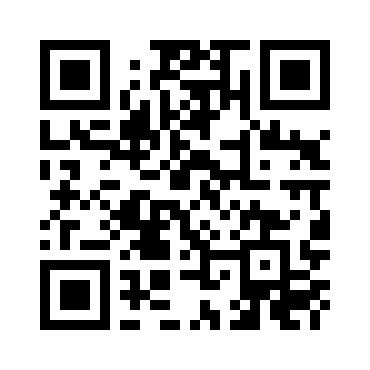

In [ ]:
# Display the link as a QR code for easy testing on a mobile device.
!pip install -q qrcode
import qrcode
qrcode.make(url)

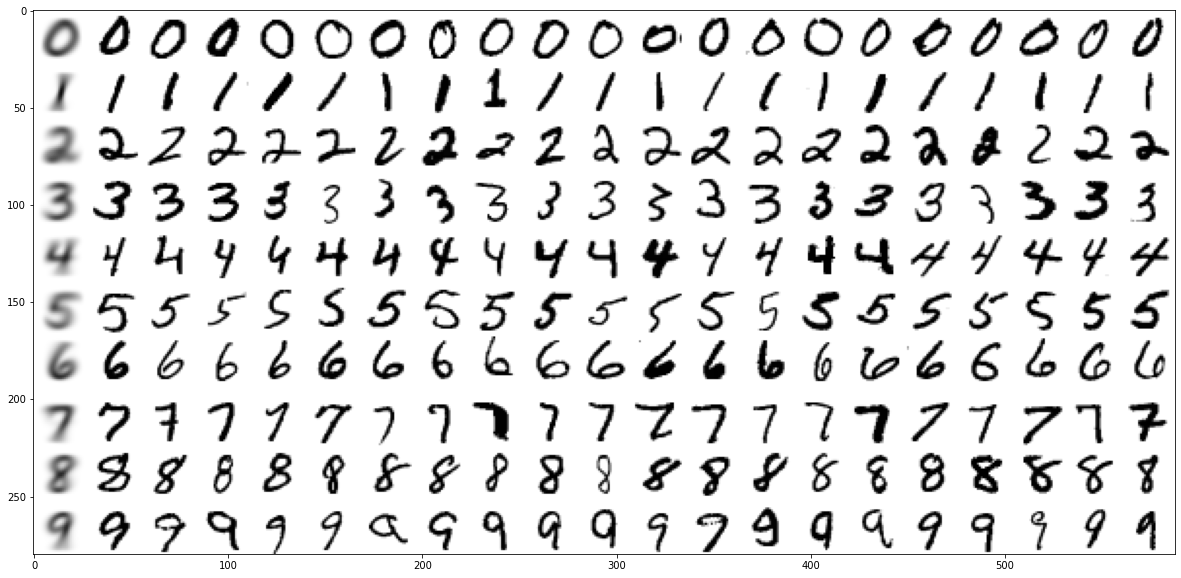

In [ ]:
# Surprised that a model with 99.1% test accuracy doesn't recognize the digits
# you draw on the phone?
# You can try drawing them more similar to what the model has seen during
# training; see below figure for the "average digit" and some samples:
plt.figure(figsize=(21, 10))
mean = np.vstack([
    np.mean(train_ds['image'][train_ds['label']==label], axis=0)[..., 0]
    for label in range(10)
])
samples = np.vstack([
    np.hstack([
        img[..., 0]
        for img in train_ds['image'][train_ds['label']==label][:20]
    ])
    for label in range(10)
])
plt.imshow(np.hstack([mean, samples]), cmap='gray_r');